In [ ]:
# -*- coding: utf-8 -*-
"""
# Turkey News: Validation of Sentiment Analysis & Topic Modeling

This Google Colab notebook provides a **standalone environment** to validate the sentiment analysis (VADER) and topic modeling (LDA) results from your primary analysis.

It performs the following:
1.  Re-loads your dataset.
2.  Re-runs necessary preprocessing and VADER sentiment analysis.
3.  Re-runs LDA topic modeling to assign topics to articles.
4.  **Validates Sentiment:** Compares VADER's output against a pre-trained Hugging Face Transformer model on a sample of articles.
5.  **Validates Topics:** Provides sample articles for manual inspection per topic, using your previously interpreted topic names.

## Dataset: News about Turkey from BBC, CNN, The Guardian, and FOX
Link: https://www.kaggle.com/datasets/muratiik/news-about-turkey-from-bbc-cnn-tg-and-fox

**Instructions:**
1.  **Open a brand new Google Colab notebook.**
2.  **Copy and paste all cells from this immersive block into your new notebook.**
3.  **Run each cell sequentially.**
4.  **Upload your dataset:** After running Cell 2, you will be prompted to upload the `Turkey_News.csv` file.
5.  **Review column names:** This notebook assumes `TEXT_COLUMN = 'content'`, `SOURCE_COLUMN = 'newsSource'`, and `DATE_COLUMN = 'date'`. Adjust in Cell 3 if your CSV uses different names.
6.  **Topic Names (Cell 7):** Ensure the `topic_names_map` in Cell 7 reflects the final, interpreted names for your 10 topics from your `pyLDAvis` analysis in the main notebook.

"""

# %% [markdown]
# ### Cell 1: Install Libraries and Download NLTK Data
# This cell installs all required Python libraries (including Gensim and Hugging Face Transformers) and downloads necessary NLTK data for text preprocessing and analysis.

# %%
# Install necessary libraries for data handling, NLP, and topic modeling
!pip install pandas matplotlib seaborn nltk vaderSentiment gensim transformers scikit-learn

# Import core libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk

# Import specific NLP modules
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

# Gensim imports for Topic Modeling
import gensim
from gensim import corpora
from gensim.models.coherencemodel import CoherenceModel
from gensim.models import LdaMulticore # For faster LDA training

# Hugging Face imports for Transformer-based Sentiment
from transformers import pipeline

# Scikit-learn for validation metrics
from sklearn.metrics import accuracy_score, confusion_matrix, cohen_kappa_score
import numpy as np

# Download NLTK data components
# These are essential for preprocessing and VADER sentiment analysis
try:
    nltk.data.find('corpora/stopwords')
except LookupError: # Catch LookupError for resource not found
    nltk.download('stopwords')
try:
    nltk.data.find('corpora/wordnet')
except LookupError: # Catch LookupError for resource not found
    nltk.download('wordnet')
try:
    nltk.data.find('tokenizers/punkt') # Required for gensim.utils.simple_preprocess
except LookupError: # Catch LookupError for resource not found
    nltk.download('punkt')
try:
    nltk.data.find('sentiment/vader_lexicon.zip') # Required for VADER sentiment analysis
except LookupError: # Catch LookupError for resource not found
    nltk.download('vader_lexicon')

print("Libraries installed and NLTK data downloaded!")


# ### Cell 2: Upload and Load Dataset
# This cell handles uploading your `Turkey_News.csv` file from your local machine to the Colab environment and then loads it into a pandas DataFrame.

# %%
# Import files module for Colab upload
from google.colab import files

# Upload the dataset
# You will be prompted to select the 'Turkey_News.csv' file.
print("Please upload your 'Turkey_News.csv' file now.")
uploaded = files.upload()

# Get the filename from the uploaded dictionary
file_name = list(uploaded.keys())[0]

# Load the dataset into a pandas DataFrame
try:
    df = pd.read_csv(file_name)
    print(f"\nDataset '{file_name}' loaded successfully!")
    print("First 5 rows of the dataset:")
    print(df.head())
    print("\nDataset Information:")
    df.info()
except Exception as e:
    print(f"Error loading the dataset: {e}")
    print("Please ensure the uploaded file is a CSV and named 'Turkey_News.csv'.")


# %% [markdown]

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


Libraries installed and NLTK data downloaded!
Please upload your 'Turkey_News.csv' file now.


[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


Saving Turkey_News.csv to Turkey_News.csv

Dataset 'Turkey_News.csv' loaded successfully!
First 5 rows of the dataset:
  newsSource keywords                                              title  \
0        bbc  TURKIYE                             Turkey country profile   
1        bbc  TURKIYE  Turkey earthquake: Before and after pictures s...   
2        bbc  TURKIYE  Turkey earthquake: Deadly new tremor traps peo...   
3        bbc  TURKIYE  Turkey earthquake: Death toll could increase e...   
4        bbc  TURKIYE  Turkey earthquake: Erdogan announces three-mon...   

                                             content  \
0  Once the centre of the Ottoman Empire the mode...   
1  Two huge earthquakes and a series of aftershoc...   
2  WATCH: Dashcam footage shows moment of new Tur...   
3  Dramatic social media footage from first quake...   
4  Turkey and Syria earthquake: Drone footage sho...   

                                             authour         date  \
0                 

In [ ]:
# ### Cell 3: Data Preprocessing & VADER Sentiment Analysis
# This cell performs all necessary text cleaning and then applies VADER sentiment analysis, storing the results in new DataFrame columns.
#
# **IMPORTANT:** The `TEXT_COLUMN`, `SOURCE_COLUMN`, and `DATE_COLUMN` variables are configured based on the common structure of the "News about Turkey" Kaggle dataset. Adjust them if your CSV has different column names.

# %%
# IMPORTANT:
# Adjust these column names if your CSV file uses different headers.
TEXT_COLUMN = 'content'      # Column containing the main article text
SOURCE_COLUMN = 'newsSource' # Column containing the news outlet name
DATE_COLUMN = 'date'         # Column containing the article publication date

# Initialize NLP tools
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()
analyzer = SentimentIntensityAnalyzer() # VADER sentiment analyzer

# Define a robust text preprocessing function
def preprocess_text_for_nlp(text):
    if not isinstance(text, str): # Handle non-string types (e.g., NaN, None)
        return ""
    text = text.lower()
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE) # Remove URLs
    text = re.sub(r'\d+', '', text) # Remove digits
    text = re.sub(r'[^\w\s]', '', text) # Remove punctuation and special characters, keep words and spaces
    return text

# Apply preprocessing to the text column
if TEXT_COLUMN not in df.columns:
    print(f"Error: Text column '{TEXT_COLUMN}' not found. Available columns: {df.columns.tolist()}")
else:
    df['cleaned_text'] = df[TEXT_COLUMN].apply(preprocess_text_for_nlp)
    print(f"\nText from '{TEXT_COLUMN}' column preprocessed and stored in 'cleaned_text'.")
    print("Sample of cleaned text:")
    print(df[[SOURCE_COLUMN, TEXT_COLUMN, 'cleaned_text']].head())

    # Perform VADER Sentiment Analysis
    df['vader_sentiment'] = df['cleaned_text'].apply(lambda text: analyzer.polarity_scores(text)['compound'])

    def categorize_sentiment(score):
        if score >= 0.05: return 'Positive'
        elif score <= -0.05: return 'Negative'
        else: return 'Neutral'
    df['sentiment_category'] = df['vader_sentiment'].apply(categorize_sentiment)
    print("\nVADER sentiment scores and categories calculated.")


# %% [markdown]


Text from 'content' column preprocessed and stored in 'cleaned_text'.
Sample of cleaned text:
  newsSource                                            content  \
0        bbc  Once the centre of the Ottoman Empire the mode...   
1        bbc  Two huge earthquakes and a series of aftershoc...   
2        bbc  WATCH: Dashcam footage shows moment of new Tur...   
3        bbc  Dramatic social media footage from first quake...   
4        bbc  Turkey and Syria earthquake: Drone footage sho...   

                                        cleaned_text  
0  once the centre of the ottoman empire the mode...  
1  two huge earthquakes and a series of aftershoc...  
2  watch dashcam footage shows moment of new turk...  
3  dramatic social media footage from first quake...  
4  turkey and syria earthquake drone footage show...  

VADER sentiment scores and categories calculated.


In [ ]:
# ### Cell 4: Prepare Data for Topic Model (Gensim Corpus)
# This cell tokenizes the cleaned text, forms bigrams and trigrams, and creates the dictionary and corpus required for LDA modeling with Gensim. This is a crucial step for the topic model.

# %%
# Function to further process words (tokenize, remove stopwords, lemmatize)
def process_words_for_gensim(texts, stop_words, lemmatizer):
    for text in texts:
        if isinstance(text, str) and text.strip(): # Ensure text is a non-empty string
            # gensim.utils.simple_preprocess performs tokenization and lowercasing
            yield [lemmatizer.lemmatize(word) for word in gensim.utils.simple_preprocess(text) if word not in stop_words]
        else:
            yield [] # Yield empty list for empty/invalid entries

# Create a list of processed texts (documents) for Gensim
data_words_gensim = list(process_words_for_gensim(df['cleaned_text'], stop_words, lemmatizer))

# Build the bigram and trigram models
# min_count: Ignore all words/bigrams with total occurrence lower than this.
# threshold: Higher threshold -> fewer phrases. Adjust if too many/few bigrams/trigrams are formed.
bigram = gensim.models.Phrases(data_words_gensim, min_count=5, threshold=100)
trigram = gensim.models.Phrases(bigram[data_words_gensim], threshold=100)

# Apply the phrase models to form bigrams and trigrams efficiently
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

# Form Bigrams and Trigrams for topic modeling
# Using trigrams as a default for potentially richer topics
data_words_final = make_trigrams(data_words_gensim)

# Create Dictionary (mapping unique words to IDs)
id2word = corpora.Dictionary(data_words_final)

# Filter out extreme words (very rare or very common)
# no_below: Remove tokens that appear in fewer than X documents.
# no_above: Remove tokens that appear in more than X (fraction) of documents.
# keep_n: Keep only the most frequent N tokens.
id2word.filter_extremes(no_below=10, no_above=0.5, keep_n=100000)

# Create Corpus (Bag-of-Words representation)
# Converts each document into a list of (word_id, word_count) tuples.
corpus = [id2word.doc2bow(text) for text in data_words_final]

print(f"\nPrepared {len(corpus)} documents for topic modeling.")
print(f"Dictionary contains {len(id2word)} unique tokens after filtering.")
print("Sample of first document's BoW representation:", corpus[0] if corpus else "Corpus is empty.")

# Check if corpus is empty or invalid
if not corpus:
    print("Warning: Corpus is empty. Topic modeling cannot be performed in subsequent cells.")
elif not id2word:
    print("Warning: Dictionary is empty. Topic modeling cannot be performed in subsequent cells.")
elif any(not doc for doc in corpus):
    print("Note: Some documents in the corpus are empty. This is expected if original 'content' was empty or heavily filtered.")


# %% [markdown]


Prepared 8386 documents for topic modeling.
Dictionary contains 21152 unique tokens after filtering.
Sample of first document's BoW representation: [(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1), (11, 1), (12, 1), (13, 2), (14, 1), (15, 1), (16, 1), (17, 1), (18, 1), (19, 2), (20, 1), (21, 1), (22, 1), (23, 1), (24, 1), (25, 2), (26, 1), (27, 2), (28, 1), (29, 2), (30, 1), (31, 1), (32, 1), (33, 1), (34, 1), (35, 1), (36, 1), (37, 1), (38, 1), (39, 1), (40, 1), (41, 1), (42, 1), (43, 1), (44, 1), (45, 1), (46, 1), (47, 1), (48, 1), (49, 1), (50, 1), (51, 1), (52, 2), (53, 1), (54, 1), (55, 1), (56, 1), (57, 1), (58, 1), (59, 2), (60, 1), (61, 1), (62, 1), (63, 2), (64, 1), (65, 1), (66, 1), (67, 1), (68, 1), (69, 1), (70, 1), (71, 1), (72, 1), (73, 1), (74, 1), (75, 1), (76, 1), (77, 1), (78, 1), (79, 1), (80, 1), (81, 1), (82, 1), (83, 1), (84, 1), (85, 1), (86, 1), (87, 1), (88, 1), (89, 1), (90, 3), (91, 1), (92, 1), (93, 1), (94, 2), (95, 

In [ ]:
# ### Cell 5: Train LDA Topic Model
# This cell trains the Latent Dirichlet Allocation (LDA) model using the prepared corpus and dictionary. This is a crucial step for assigning topics to articles.
#
# **Note:** The `NUM_TOPICS` value (10) is set based on your previous analysis.

# %%
# Number of topics (from previous analysis)
NUM_TOPICS = 10

# Train the LDA model
try:
    if not corpus or not id2word:
        raise ValueError("Corpus or Dictionary is empty. Cannot train LDA model.")

    lda_model = LdaMulticore(corpus=corpus,
                             id2word=id2word,
                             num_topics=NUM_TOPICS,
                             random_state=100, # For reproducibility
                             chunksize=100,    # Number of documents to be used in each training chunk
                             passes=10,        # Number of passes through the entire corpus
                             per_word_topics=True, # Needed for pyLDAvis (though not displayed here)
                             workers=None)     # Use all available cores (or specify an integer)

    print(f"\nLDA model trained with {NUM_TOPICS} topics.")
    print("Top 10 words for each topic (most relevant keywords):")
    for idx, topic in lda_model.print_topics(num_words=10):
        print(f"Topic {idx}: {topic}")

    # Calculate Coherence Score (a measure of topic interpretability)
    coherence_model_lda = CoherenceModel(model=lda_model, texts=data_words_final, dictionary=id2word, coherence='c_v')
    coherence_lda = coherence_model_lda.get_coherence()
    print(f"\nModel Coherence Score (c_v): {coherence_lda:.3f}")

except ValueError as ve:
    print(f"Error training LDA model: {ve}")
except Exception as e:
    print(f"An unexpected error occurred during LDA training: {e}")


# %% [markdown]


LDA model trained with 10 topics.
Top 10 words for each topic (most relevant keywords):
Topic 0: 0.036*"syria" + 0.033*"syrian" + 0.015*"opposition" + 0.014*"iran" + 0.013*"regime" + 0.013*"israel" + 0.008*"rebel" + 0.007*"group" + 0.007*"state" + 0.007*"israeli"
Topic 1: 0.021*"syria" + 0.019*"turkish" + 0.017*"force" + 0.017*"isi" + 0.016*"attack" + 0.016*"group" + 0.014*"kurdish" + 0.011*"military" + 0.010*"syrian" + 0.009*"official"
Topic 2: 0.012*"australia" + 0.011*"australian" + 0.008*"uk" + 0.007*"world" + 0.007*"health" + 0.007*"first" + 0.007*"team" + 0.005*"new" + 0.005*"million" + 0.005*"player"
Topic 3: 0.014*"turkish" + 0.010*"president" + 0.009*"erdogan" + 0.008*"party" + 0.008*"state" + 0.007*"trump" + 0.007*"erdoğan" + 0.007*"election" + 0.006*"political" + 0.005*"journalist"
Topic 4: 0.021*"city" + 0.021*"istanbul" + 0.019*"turkish" + 0.009*"building" + 0.009*"police" + 0.008*"street" + 0.007*"world" + 0.007*"town" + 0.006*"site" + 0.006*"local"
Topic 5: 0.012*"compa

In [ ]:
# ### Cell 6: Assign Dominant Topics to Articles
# This cell assigns the most dominant topic to each original article based on the trained LDA model.

# %%
# Function to get the dominant topic for each document
def format_topics_sentences(ldamodel, corpus, texts):
    # Init output DataFrame
    sent_topics_df = pd.DataFrame()

    # Get main topic for each document
    for i, row_list in enumerate(ldamodel[corpus]):
        if not row_list: # Handle empty documents/rows in corpus
            sent_topics_df = pd.concat([sent_topics_df, pd.DataFrame([[None, 0.0, "No Topic Found"]])], ignore_index=True)
            continue

        topic_distribution = row_list[0] if ldamodel.per_word_topics else row_list
        topic_distribution = sorted(topic_distribution, key=lambda x: (x[1]), reverse=True)

        dominant_topic_num, prop_topic = topic_distribution[0] # Take the top topic

        wp = ldamodel.show_topic(dominant_topic_num)
        topic_keywords = ", ".join([word for word, prop in wp])

        sent_topics_df = pd.concat([sent_topics_df, pd.DataFrame([[int(dominant_topic_num), round(prop_topic,4), topic_keywords]])], ignore_index=True)

    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text (cleaned) for reference if needed. Reset index for clean concat.
    contents = pd.Series(texts).reset_index(drop=True)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return sent_topics_df

try:
    if df.empty:
        raise ValueError("DataFrame 'df' not loaded or is empty. Please run Cell 2 first.")
    if 'lda_model' not in locals() or not lda_model:
        raise ValueError("LDA model not trained. Please run Cell 5 first.")
    if not corpus:
        raise ValueError("Corpus is empty. Please run Cell 4 first.")

    # Get the dominant topic and its percentage contribution for each document
    df_topic_sents_keywords = format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=df['cleaned_text'])

    # Merge with the main DataFrame using index alignment
    df_with_topics = df.copy()
    df_with_topics.reset_index(drop=True, inplace=True)
    df_topic_sents_keywords.reset_index(drop=True, inplace=True)
    df_with_topics = pd.concat([df_with_topics, df_topic_sents_keywords], axis=1)

    print("\nDominant topics assigned to each article and merged into 'df_with_topics'.")
    print("Sample with assigned topics:")
    print(df_with_topics[[SOURCE_COLUMN, 'title', 'Dominant_Topic', 'Topic_Keywords']].head())

except ValueError as ve:
    print(f"Error: {ve}")
except Exception as e:
    print(f"An unexpected error occurred in Cell 6 (topic assignment): {e}")


# %% [markdown]


Dominant topics assigned to each article and merged into 'df_with_topics'.
Sample with assigned topics:
  newsSource                                              title  \
0        bbc                             Turkey country profile   
1        bbc  Turkey earthquake: Before and after pictures s...   
2        bbc  Turkey earthquake: Deadly new tremor traps peo...   
3        bbc  Turkey earthquake: Death toll could increase e...   
4        bbc  Turkey earthquake: Erdogan announces three-mon...   

   Dominant_Topic                                     Topic_Keywords  
0               3  turkish, president, erdogan, party, state, tru...  
1               7  refugee, earthquake, syria, border, child, syr...  
2               7  refugee, earthquake, syria, border, child, syr...  
3               7  refugee, earthquake, syria, border, child, syr...  
4               7  refugee, earthquake, syria, border, child, syr...  


--- Starting Validation Processes ---

--- 1. Validating Sentiment Analysis with Hugging Face Transformer Model ---
Loading Hugging Face sentiment analysis model ('nlptown/bert-base-multilingual-uncased-sentiment')...


config.json:   0%|          | 0.00/953 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/669M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/39.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/872k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

Device set to use cpu


Analyzing sentiment for a random sample of 1000 articles using Hugging Face model (one by one for robustness)...

--- Sentiment Comparison Metrics ---
Accuracy of VADER vs. HF (Category Match): 0.60

Confusion Matrix (VADER vs. HF):
                HF Positive  HF Neutral  HF Negative
VADER Positive           23          26          337
VADER Neutral             0           0            5
VADER Negative           19          16          574

Cohen's Kappa Score (Category Match): 0.05 (Interpretation: <0.20=Slight, 0.21-0.40=Fair, 0.41-0.60=Moderate, 0.61-0.80=Substantial, >0.80=Almost Perfect)

Pearson Correlation between VADER Compound Score and HF Compound-like Score: 0.27
Interpretation: Closer to 1 means strong positive correlation, closer to -1 means strong negative correlation.


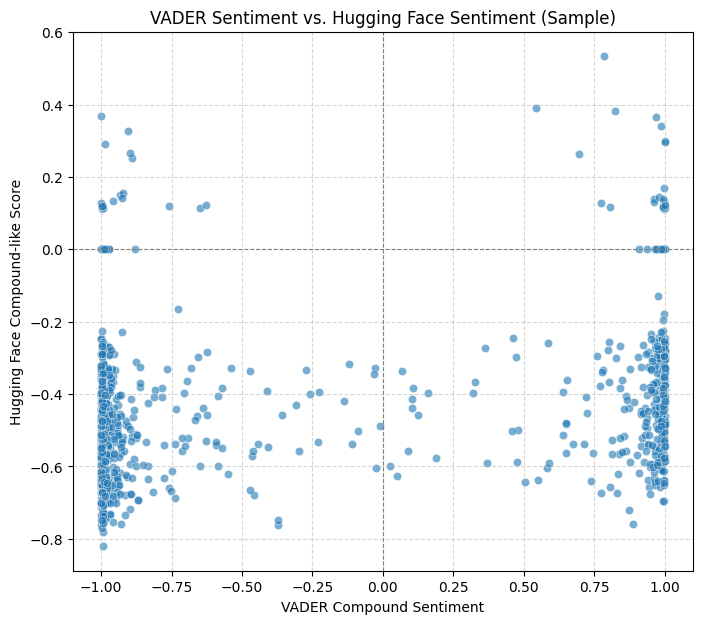


--- 2. Validating Topic Modeling (Qualitative Assessment) ---

LDA Model Coherence Score (c_v, from Cell 5): 0.500
Interpretation: A score closer to 1.0 indicates more interpretable topics.

--- Manual Topic Interpretation Guidance ---
To qualitatively validate topics, manually inspect articles assigned to each topic.
This helps confirm if the topic keywords truly represent the content of the articles.

--- Sample Articles for Manual Topic Validation ---

--- Topic 0: Geopolitics (Syria/Iran/Israel) ---
  Keywords: syria, syrian, opposition, iran, regime, israel, rebel, group, state, israeli
  Sample Articles:
    - Title: Turkey may welcome Muslim Brotherhood brass after ouster from Qatar
      Source: fox, Sentiment: Positive
      Content Snippet: Turkish President Recep Tayyip Erdogan may welcome Muslim Brotherhood leaders after they were kicked out of Qatar. (AP Photo) (The Associated Press)' They're pariahs in much of the Middle East but the...
----------
    - Title: Analysts: 

In [ ]:
# -*- coding: utf-8 -*-
# %% [markdown]
# ### Cell 7: Validation Processes
# This cell performs the main validation steps: comparing VADER sentiment with a Transformer model and providing samples for qualitative topic validation.
#
# **Validation Steps:**
# 1.  **Sentiment Analysis Comparison:** Compares VADER's sentiment predictions with those of a pre-trained Transformer model (Hugging Face). This helps assess the robustness of VADER's output.
# 2.  **Topic Modeling Qualitative Check:** Provides tools to sample articles for each dominant topic, allowing for manual inspection to verify topic coherence and article assignment accuracy.
#
# **Pre-requisites:** This cell assumes `df_with_topics` (containing 'cleaned_text', 'vader_sentiment', 'sentiment_category', 'Dominant_Topic', 'Topic_Keywords', and 'title') has been successfully created in previous cells (e.g., Cell 6).

# %%
print("--- Starting Validation Processes ---")

# --- 1. Sentiment Analysis Validation (Comparison with Hugging Face Transformer) ---
print("\n--- 1. Validating Sentiment Analysis with Hugging Face Transformer Model ---")

try:
    if 'df_with_topics' not in locals() or df_with_topics.empty:
        raise ValueError("df_with_topics not found or is empty. Please run Cell 6 first.")

    # Initialize the sentiment analysis pipeline from Hugging Face
    # CHANGED MODEL: Using a more general-purpose BERT-based sentiment model ('nlptown/bert-base-multilingual-uncased-sentiment')
    # This model outputs labels like '1 star' to '5 stars'. We will map these to Positive/Neutral/Negative.
    print("Loading Hugging Face sentiment analysis model ('nlptown/bert-base-multilingual-uncased-sentiment')...")
    hf_sentiment_pipeline = pipeline("sentiment-analysis", model="nlptown/bert-base-multilingual-uncased-sentiment")

    # Take a random sample for validation to keep runtime manageable (e.g., 500 articles)
    sample_size = min(1000, len(df_with_topics)) # Max 1000 or full dataset if smaller
    df_sample = df_with_topics.sample(n=sample_size, random_state=42).copy()

    print(f"Analyzing sentiment for a random sample of {sample_size} articles using Hugging Face model (one by one for robustness)...")

    # Map the 5-star output of the new HF model to 3 categories and a compound-like score
    def map_hf_5star_to_vader_style(hf_label, hf_score):
        # hf_label will be like '1 star', '2 stars', ..., '5 stars'
        star_rating = int(hf_label.split(' ')[0]) # Extract the number

        # Map to 3 categories
        if star_rating >= 4: # 4 or 5 stars
            category = 'Positive'
        elif star_rating <= 2: # 1 or 2 stars
            category = 'Negative'
        else: # 3 stars
            category = 'Neutral'

        # Map to a compound-like score (-1 to 1 range)
        # Scale stars 1-5 to -1 to 1: (star - 3) / 2
        compound_like_score = (star_rating - 3) / 2.0 * hf_score # Incorporate confidence score

        return category, compound_like_score

    hf_categories_full = []
    hf_compound_likes_full = []

    # Process each text individually for maximum robustness against batching/tensor errors
    for idx, row in df_sample.iterrows():
        text_item = str(row['cleaned_text'])

        # If text is empty or just whitespace, assign neutral and skip pipeline call
        if not text_item.strip():
            hf_categories_full.append('Neutral')
            hf_compound_likes_full.append(0.0)
            continue

        try:
            # Process single text item. The pipeline returns a list containing one dict.
            result = hf_sentiment_pipeline(text_item, truncation=True, padding=True, max_length=512)[0]

            # Map the HF result to our standard categories and compound-like score
            category, compound_like = map_hf_5star_to_vader_style(result['label'], result['score'])

            hf_categories_full.append(category)
            hf_compound_likes_full.append(compound_like)

        except Exception as e:
            # Catch any error during processing of a single text
            print(f"Warning: Error processing text at index {idx} with HF pipeline: {e}. Assigning Neutral.")
            hf_categories_full.append('Neutral')
            hf_compound_likes_full.append(0.0)

    df_sample['hf_category'] = hf_categories_full
    df_sample['hf_compound_like'] = hf_compound_likes_full

    # --- Sentiment Comparison Metrics ---
    print("\n--- Sentiment Comparison Metrics ---")

    # 1. Category Agreement (Accuracy & Confusion Matrix)
    all_categories = ['Positive', 'Neutral', 'Negative']

    accuracy_cat = accuracy_score(df_sample['sentiment_category'], df_sample['hf_category'])
    print(f"Accuracy of VADER vs. HF (Category Match): {accuracy_cat:.2f}")

    print("\nConfusion Matrix (VADER vs. HF):")
    cm = confusion_matrix(df_sample['sentiment_category'], df_sample['hf_category'], labels=all_categories)
    cm_df = pd.DataFrame(cm, index=[f"VADER {cat}" for cat in all_categories],
                         columns=[f"HF {cat}" for cat in all_categories])
    print(cm_df)

    kappa_score = cohen_kappa_score(df_sample['sentiment_category'], df_sample['hf_category'])
    print(f"\nCohen's Kappa Score (Category Match): {kappa_score:.2f} (Interpretation: <0.20=Slight, 0.21-0.40=Fair, 0.41-0.60=Moderate, 0.61-0.80=Substantial, >0.80=Almost Perfect)")

    # 2. Correlation of Scores (for numerical comparison)
    correlation_score = df_sample['vader_sentiment'].corr(df_sample['hf_compound_like'])
    print(f"\nPearson Correlation between VADER Compound Score and HF Compound-like Score: {correlation_score:.2f}")
    print("Interpretation: Closer to 1 means strong positive correlation, closer to -1 means strong negative correlation.")

    # Visualize score correlation (Scatter plot)
    plt.figure(figsize=(8, 7))
    sns.scatterplot(x='vader_sentiment', y='hf_compound_like', data=df_sample, alpha=0.6)
    plt.title('VADER Sentiment vs. Hugging Face Sentiment (Sample)')
    plt.xlabel('VADER Compound Sentiment')
    plt.ylabel('Hugging Face Compound-like Score')
    plt.axvline(0, color='grey', linestyle='--', linewidth=0.8)
    plt.axhline(0, color='grey', linestyle='--', linewidth=0.8)
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.show()


except Exception as e:
    print(f"An unexpected error occurred during sentiment validation: {e}")
    print("Please check previous cell outputs and ensure necessary libraries are installed.")

# --- 2. Validating Topic Modeling (Qualitative Assessment) ---
print("\n--- 2. Validating Topic Modeling (Qualitative Assessment) ---")

try:
    if 'df_with_topics' not in locals() or df_with_topics.empty:
        raise ValueError("df_with_topics not found or is empty. Please run Cell 6 first.")

    # Reiterate Coherence Score (from LDA training in Cell 5)
    if 'coherence_lda' in globals():
        print(f"\nLDA Model Coherence Score (c_v, from Cell 5): {coherence_lda:.3f}")
        print("Interpretation: A score closer to 1.0 indicates more interpretable topics.")
    else:
        print("LDA Coherence Score (coherence_lda) not found in global scope. Please ensure LDA training cell (Cell 5) was run successfully before this validation cell.")

    print("\n--- Manual Topic Interpretation Guidance ---")
    print("To qualitatively validate topics, manually inspect articles assigned to each topic.")
    print("This helps confirm if the topic keywords truly represent the content of the articles.")

    # Mapping topic numbers to names for clearer output (from your pyLDAvis interpretation)
    # IMPORTANT: Update these topic names with your FINAL interpreted topic names.
    topic_names_map = {
        0: "Geopolitics (Syria/Iran/Israel)",
        1: "Turkish Military & Kurdish Conflict",
        2: "Intl. Affairs & Global Context",
        3: "Domestic Politics & Leadership",
        4: "Urban/Spatial & Security",
        5: "Business & Aviation Incidents",
        6: "Russia/Ukraine/NATO Relations",
        7: "Refugee/Earthquake/Humanitarian",
        8: "Personal Narratives/Social",
        9: "Food, Culture & Lifestyle"
    }

    # Display 3 sample articles for each dominant topic for manual review
    print("\n--- Sample Articles for Manual Topic Validation ---")
    for i in sorted(df_with_topics['Dominant_Topic'].unique()):
        # Ensure there are enough articles for sampling in each topic
        sample_count = min(3, len(df_with_topics[df_with_topics['Dominant_Topic'] == i]))
        if sample_count == 0:
            continue # Skip if no articles for this topic

        topic_articles = df_with_topics[df_with_topics['Dominant_Topic'] == i].sample(n=sample_count, random_state=42)

        topic_name = topic_names_map.get(i, f"Topic {i} (Unknown Name)")
        topic_keywords = topic_articles['Topic_Keywords'].iloc[0] if not topic_articles.empty else "N/A"

        print(f"\n--- Topic {i}: {topic_name} ---")
        print(f"  Keywords: {topic_keywords}")
        print("  Sample Articles:")
        for idx, row in topic_articles.iterrows():
            print(f"    - Title: {row['title']}")
            print(f"      Source: {row['newsSource']}, Sentiment: {row['sentiment_category']}")
            print(f"      Content Snippet: {row['content'][:200]}...") # Print first 200 chars
            print("-" * 10)

except Exception as e:
    print(f"An unexpected error occurred during topic modeling validation: {e}")
    print("Please ensure 'df_with_topics' is correctly populated and previous cells ran.")

print("\n--- Validation Processes Complete ---")
print("Remember to manually review the sample articles for topic coherence and interpret the sentiment comparison metrics.")


Visualizing: Topic Prevalence by News Outlet (Proportion per Source)


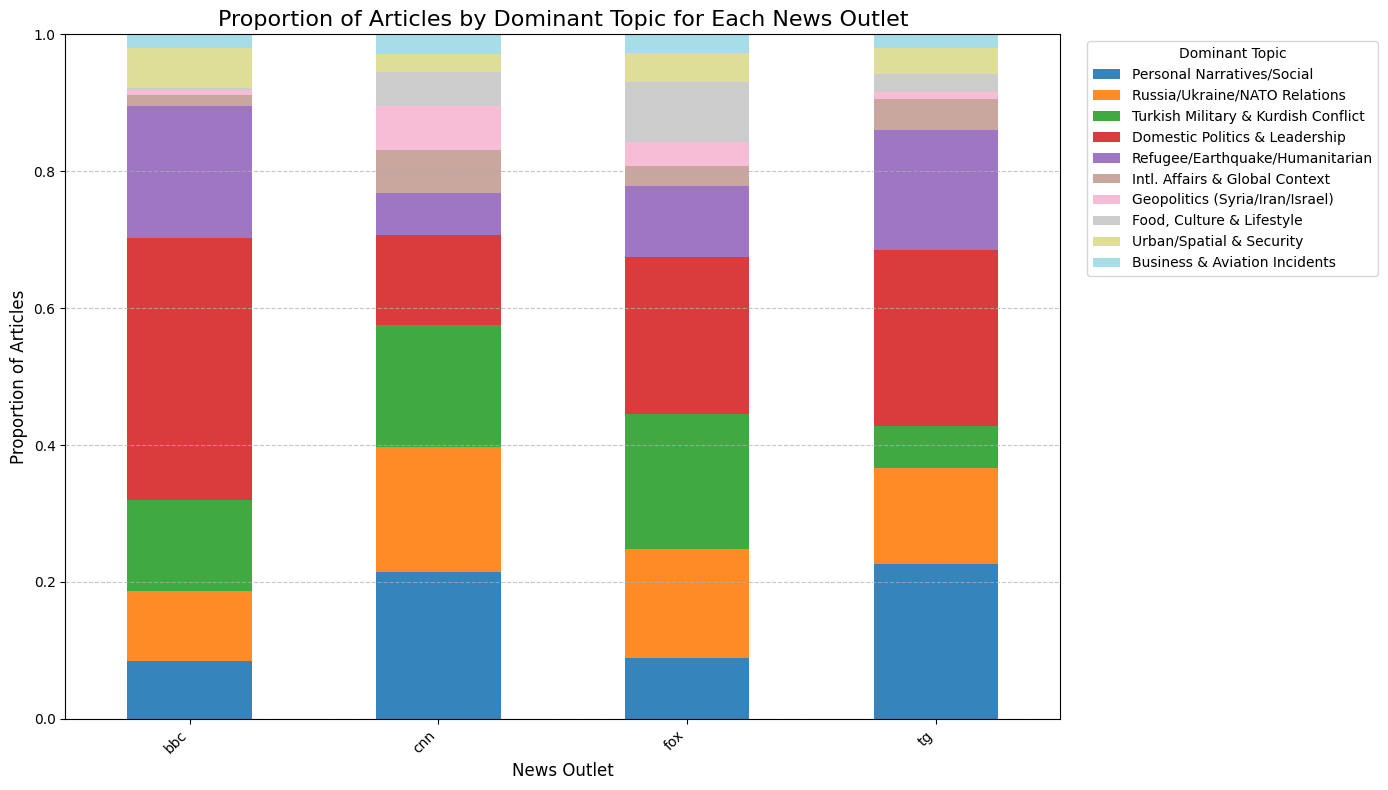


Topic prevalence by news outlet visualization complete.


In [ ]:
# -*- coding: utf-8 -*-
# %% [markdown]
# ### Cell 9: Topic Prevalence by News Outlet
# This cell visualizes the **proportion of each dominant topic within the coverage of each individual news outlet**. This helps to understand if different news sources prioritize different aspects of Turkey.
#
# **Pre-requisites:** Relies on `df_with_topics` created in Cell 7.

# %%
if 'df_with_topics' not in locals() or df_with_topics.empty:
    print("Error: 'df_with_topics' DataFrame not found or is empty. Please ensure Cell 7 was run successfully.")
else:
    SOURCE_COLUMN = 'newsSource' # Assuming 'newsSource' is still the correct column name

    print("\nVisualizing: Topic Prevalence by News Outlet (Proportion per Source)")

    # IMPORTANT: Update these topic names with your FINAL interpreted topic names from pyLDAvis (Cell 6)
    topic_names = {
        0: "Geopolitics (Syria/Iran/Israel)",
        1: "Turkish Military & Kurdish Conflict",
        2: "Intl. Affairs & Global Context",
        3: "Domestic Politics & Leadership",
        4: "Urban/Spatial & Security",
        5: "Business & Aviation Incidents",
        6: "Russia/Ukraine/NATO Relations",
        7: "Refugee/Earthquake/Humanitarian",
        8: "Personal Narratives/Social",
        9: "Food, Culture & Lifestyle"
    }
    # Map topic numbers to names for better readability in the plot
    df_with_topics['Dominant_Topic_Name'] = df_with_topics['Dominant_Topic'].map(topic_names)

    # Calculate count of articles per source per topic
    topic_counts_per_source = df_with_topics.groupby([SOURCE_COLUMN, 'Dominant_Topic_Name']).size().unstack(fill_value=0)

    # Calculate proportions
    topic_proportions_per_source = topic_counts_per_source.apply(lambda x: x / x.sum(), axis=1)

    # Sort topics by their overall prevalence for consistent plotting
    overall_topic_prevalence = df_with_topics['Dominant_Topic_Name'].value_counts(normalize=True).index
    topic_proportions_per_source = topic_proportions_per_source[overall_topic_prevalence]


    # Plotting: Stacked Bar Chart for each source
    # Transpose for easier plotting (sources on X-axis, topics stacked)
    topic_proportions_per_source.plot(kind='bar', stacked=True, figsize=(14, 8), cmap='tab20', alpha=0.9)

    plt.title('Proportion of Articles by Dominant Topic for Each News Outlet', fontsize=16)
    plt.xlabel('News Outlet', fontsize=12)
    plt.ylabel('Proportion of Articles', fontsize=12)
    plt.ylim(0, 1)
    plt.xticks(rotation=45, ha='right')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.legend(title='Dominant Topic', bbox_to_anchor=(1.02, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

print("\nTopic prevalence by news outlet visualization complete.")


Visualizing: Average Sentiment by Dominant Topic and News Outlet


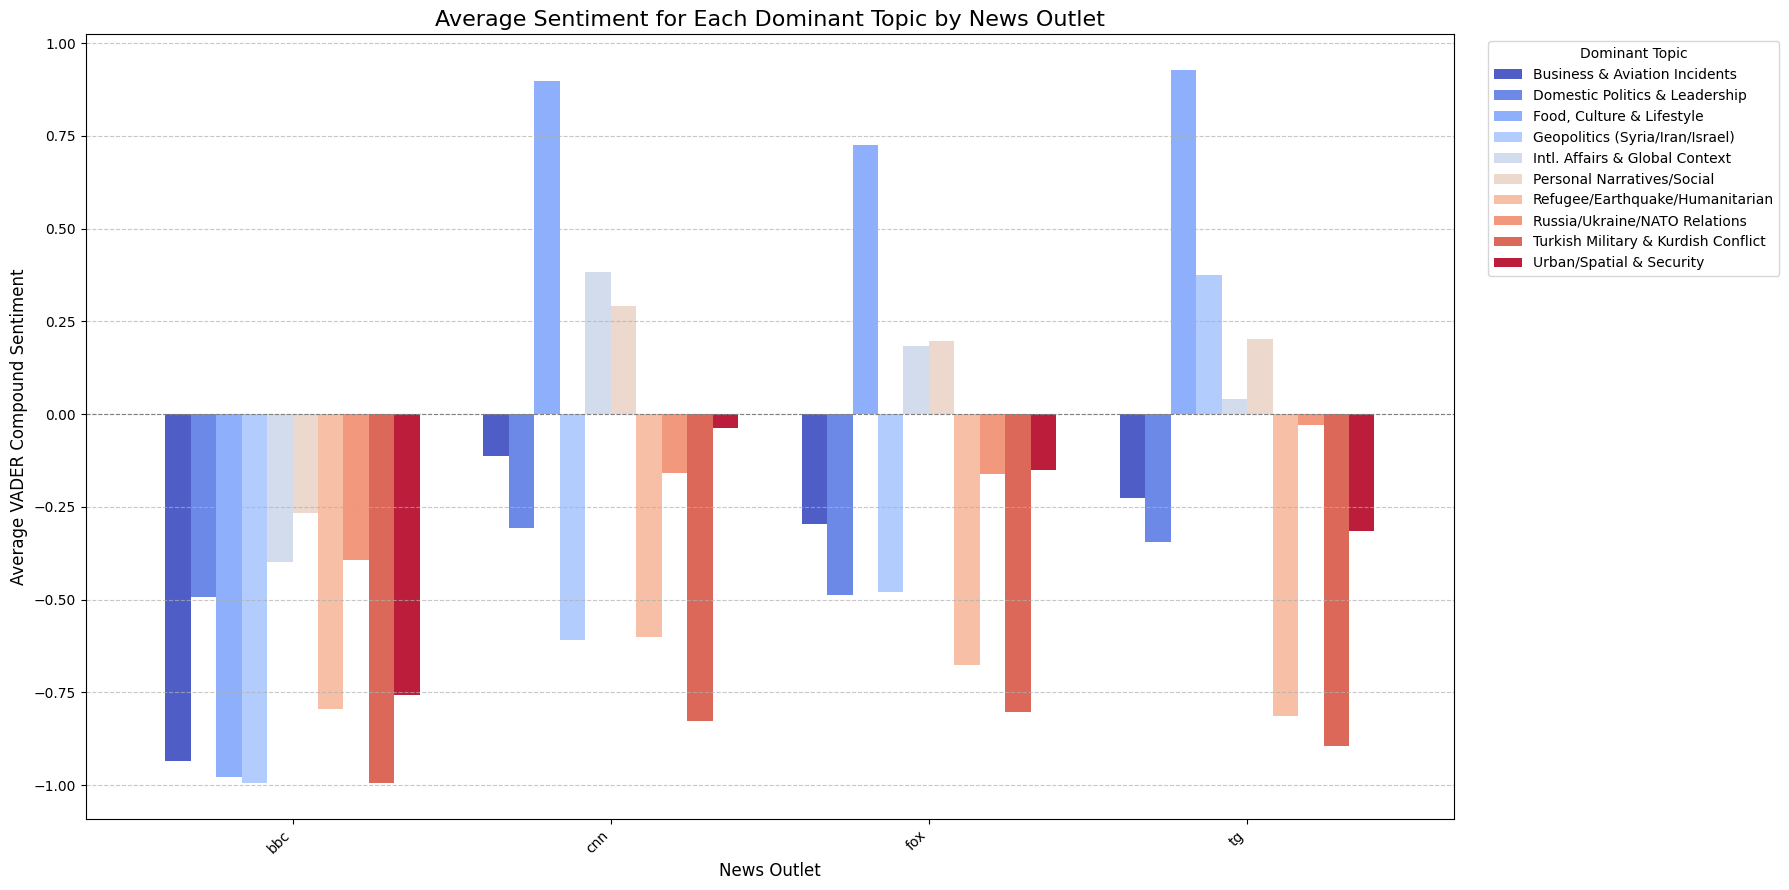

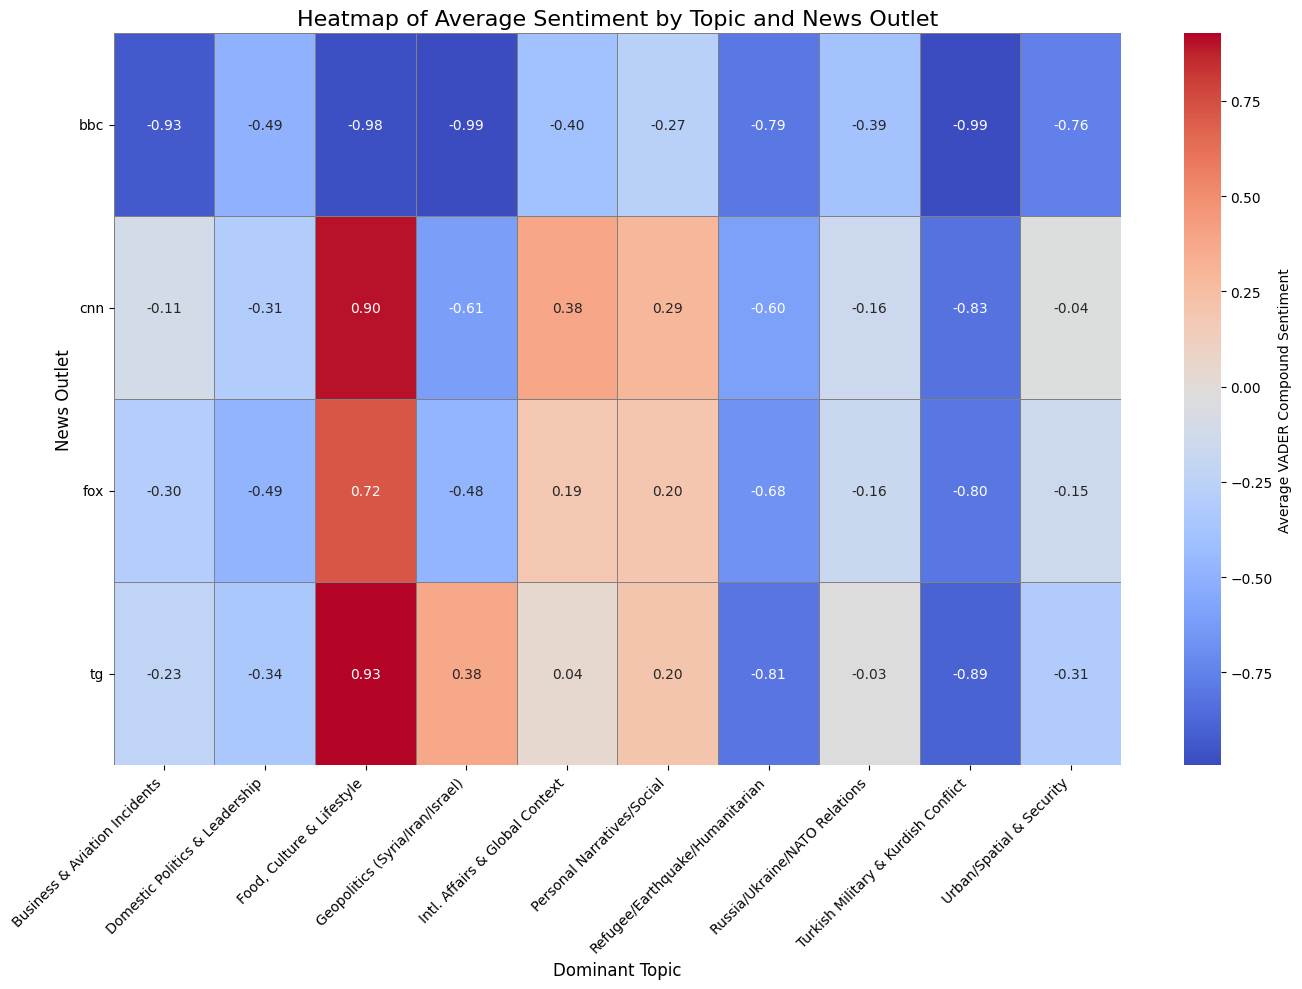


Sentiment by topic and news outlet visualizations complete.


In [ ]:
# -*- coding: utf-8 -*-
# %% [markdown]
# ### Cell 10: Sentiment by Topic and News Outlet
# This cell visualizes the **average sentiment for each dominant topic, broken down by individual news outlet**. This is crucial for understanding how different sources frame specific issues.
#
# **Pre-requisites:** Relies on `df_with_topics` created in Cell 7.

# %%
if 'df_with_topics' not in locals() or df_with_topics.empty:
    print("Error: 'df_with_topics' DataFrame not found or is empty. Please ensure Cell 7 was run successfully.")
else:
    SOURCE_COLUMN = 'newsSource' # Assuming 'newsSource' is still the correct column name

    print("\nVisualizing: Average Sentiment by Dominant Topic and News Outlet")

    # IMPORTANT: Use the same topic_names as in Cell 9 or your main notebook
    topic_names = {
        0: "Geopolitics (Syria/Iran/Israel)",
        1: "Turkish Military & Kurdish Conflict",
        2: "Intl. Affairs & Global Context",
        3: "Domestic Politics & Leadership",
        4: "Urban/Spatial & Security",
        5: "Business & Aviation Incidents",
        6: "Russia/Ukraine/NATO Relations",
        7: "Refugee/Earthquake/Humanitarian",
        8: "Personal Narratives/Social",
        9: "Food, Culture & Lifestyle"
    }
    df_with_topics['Dominant_Topic_Name'] = df_with_topics['Dominant_Topic'].map(topic_names)

    # Calculate average sentiment for each topic per news outlet
    sentiment_by_topic_and_source = df_with_topics.groupby(['Dominant_Topic_Name', SOURCE_COLUMN])['vader_sentiment'].mean().reset_index()

    # Create a pivot table for plotting (topics as columns, sources as rows)
    pivot_table = sentiment_by_topic_and_source.pivot_table(index=SOURCE_COLUMN, columns='Dominant_Topic_Name', values='vader_sentiment')

    # Sort topics by their overall sentiment for consistent comparison
    # Get the overall sentiment order from Cell 7's output if possible, or manually define a logical order
    # For now, just use the current pivot table order

    # Plotting: Grouped Bar Chart
    pivot_table.plot(kind='bar', figsize=(18, 9), cmap='coolwarm', alpha=0.9, width=0.8) # Coolwarm for sentiment

    plt.title('Average Sentiment for Each Dominant Topic by News Outlet', fontsize=16)
    plt.xlabel('News Outlet', fontsize=12)
    plt.ylabel('Average VADER Compound Sentiment', fontsize=12)
    plt.axhline(0, color='grey', linestyle='--', linewidth=0.8) # Neutrality line
    plt.xticks(rotation=45, ha='right')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.legend(title='Dominant Topic', bbox_to_anchor=(1.02, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

    # Optional: Heatmap for a different view of Sentiment by Topic and Source
    plt.figure(figsize=(14, 10))
    sns.heatmap(pivot_table, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5, linecolor='gray',
                cbar_kws={'label': 'Average VADER Compound Sentiment'})
    plt.title('Heatmap of Average Sentiment by Topic and News Outlet', fontsize=16)
    plt.xlabel('Dominant Topic', fontsize=12)
    plt.ylabel('News Outlet', fontsize=12)
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

print("\nSentiment by topic and news outlet visualizations complete.")